In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import sklearn

In [ ]:
# Importanto dataset 
covid_df = pd.read_csv("data/brazil_cities_coordinates.csv")
# Resumo do dataset
covid_df.head()

,state_code,city_code,city_name,lat,long,capital
0,52,5200050,Abadia de Goiás,-16.75730,-49.4412,False
1,31,3100104,Abadia dos Dourados,-18.48310,-47.3916,False
2,52,5200100,Abadiânia,-16.19700,-48.7057,False
3,31,3100203,Abaeté,-19.15510,-45.4444,False
4,15,1500107,Abaetetuba,-1.72183,-48.8788,False


### Análise das Variáveis do Dataset de COVID-19

O dataset utilizado contém informações geográficas e administrativas das cidades brasileiras associadas aos registros de COVID-19. As variáveis `state_code` e `city_code` correspondem a identificadores de estado e município, respectivamente, enquanto `city_name` representa apenas um rótulo textual. Essas variáveis não possuem significado métrico e, portanto, não são adequadas para métodos de clusterização baseados em distância.

As variáveis `lat` (latitude) e `long` (longitude) representam coordenadas geográficas contínuas e foram utilizadas como atributos de entrada no algoritmo K-Means. A variável `capital`, de natureza booleana, não foi utilizada diretamente na clusterização, sendo mais apropriada para análises descritivas posteriores.

In [6]:
covid_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   state_code  5570 non-null   int64  
 1   city_code   5570 non-null   int64  
 2   city_name   5570 non-null   str    
 3   lat         5570 non-null   float64
 4   long        5570 non-null   float64
 5   capital     5570 non-null   bool   
dtypes: bool(1), float64(2), int64(2), str(1)
memory usage: 223.1 KB


In [16]:
covid_df.describe()

,state_code,city_code,lat,long
count,5570.000000,5.570000e+03,5570.000000,5570.000000
mean,32.377738,3.253591e+06,-16.449144,-46.231003
std,9.833862,9.849103e+05,8.287237,6.408539
min,11.000000,1.100015e+06,-33.686600,-72.899700
25%,25.000000,2.512126e+06,-22.843875,-50.878525
50%,31.000000,3.146280e+06,-18.094300,-46.523200
75%,41.000000,4.119190e+06,-8.496445,-41.410775
max,53.000000,5.300108e+06,4.603140,-32.410700


In [26]:
# Analise exploratória dos dados
def plot_all_hist(covid_df, title_prefix = ""):
    num_cols = covid_df.select_dtypes(include=[np.number]).columns
    n_cols = 2
    n_rows = math.ceil(len(num_cols)/n_cols)
    plt.figure(figsize=(5*n_cols, 4*n_rows))

    for i, col in enumerate(num_cols,1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(covid_df[col],kde=True,bins=30)
        plt.title(f"{title_prefix} {col}")
    plt.tight_layout()
    plt.show()

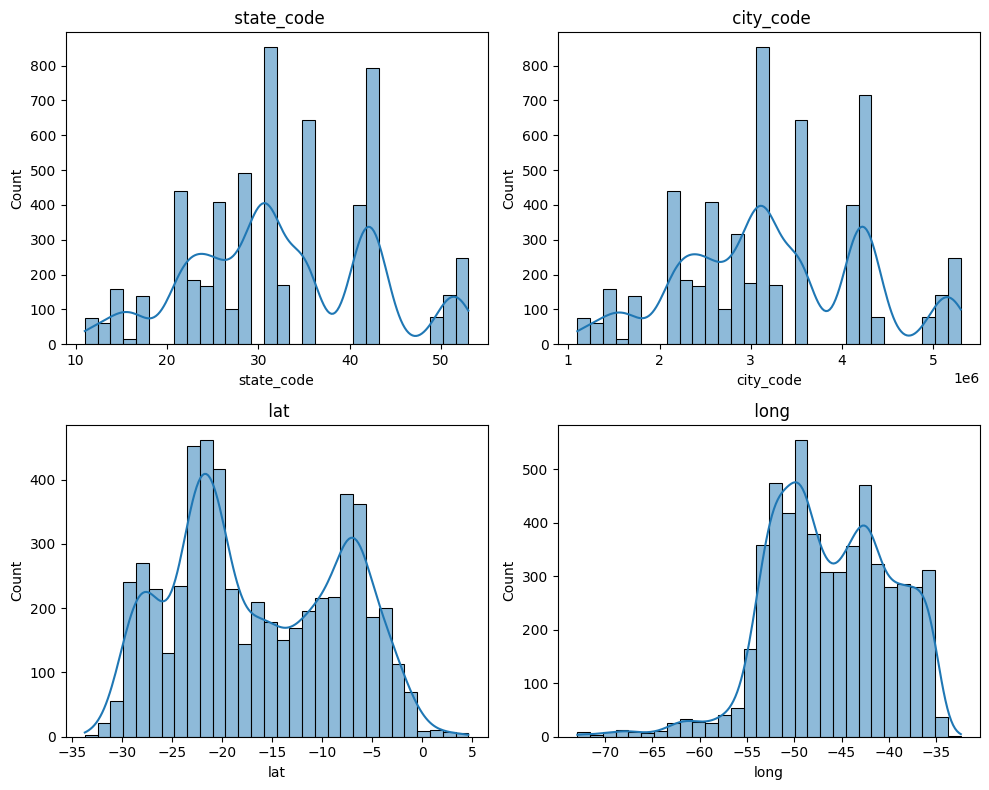

In [27]:
# Plot histograma
plot_all_hist(covid_df)

In [ ]:
# Seleciando as variáveis do covid.df que serão usadas
X_geo = covid_df[["lat", "long"]]
X_geo

,lat,long
0,-16.75730,-49.4412
1,-18.48310,-47.3916
2,-16.19700,-48.7057
3,-19.15510,-45.4444
4,-1.72183,-48.8788
...,...,...
5565,-10.82300,-42.7245
5566,-8.07901,-37.1057
5567,-21.05060,-50.0552
5568,-3.27014,-45.6553


In [38]:
# Normalização dos dados
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_geo)
X_scaled[[]]


array([], shape=(0, 2), dtype=float64)

In [ ]:
# Escolhendo o número de clusters (K)
from sklearn.cluster import KMeans

inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)


### Seleção do Número de Clusters — Método do Cotovelo

O Método do Cotovelo foi aplicado aos dados geográficos normalizados (latitude e longitude), avaliando a inércia (WGSS) para valores de K entre 1 e 10. Observa-se uma redução acentuada da inércia até K = 4, seguida de uma diminuição progressivamente menor para valores superiores de K.

Esse comportamento indica a presença de um "cotovelo" entre K = 4 e K = 5, sugerindo que a divisão dos dados em quatro clusters oferece um bom compromisso entre compactação dos grupos e simplicidade do modelo. Assim, optou-se por K = 4 para a etapa de clusterização.


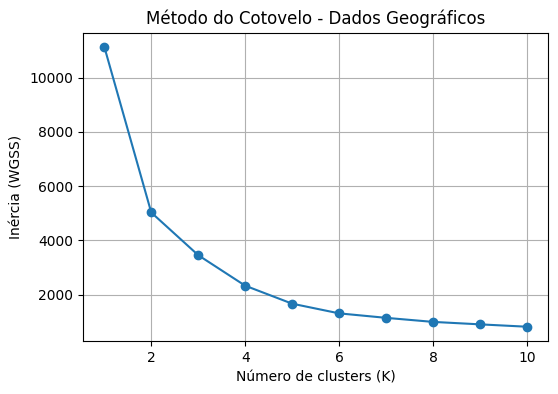

In [ ]:
# Vizualização do método cotovelo para saber qual K deveremos usar
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inércia (WGSS)")
plt.title("Método do Cotovelo - Dados Geográficos")
plt.grid(True)
plt.show()


In [41]:
# Treinando o modelo com o K-means 
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)



### Interpretação dos Clusters

Os clusters obtidos por meio do K-Means refletem exclusivamente padrões de proximidade geográfica entre as cidades brasileiras com registros de COVID-19. Dessa forma, cada cluster representa uma região espacial do território nacional, e não níveis de gravidade, incidência ou risco da doença.

Essa segmentação espacial pode ser utilizada como base para análises epidemiológicas regionais, como a comparação temporal da evolução da pandemia entre diferentes regiões, desde que variáveis epidemiológicas adicionais sejam incorporadas ao modelo.


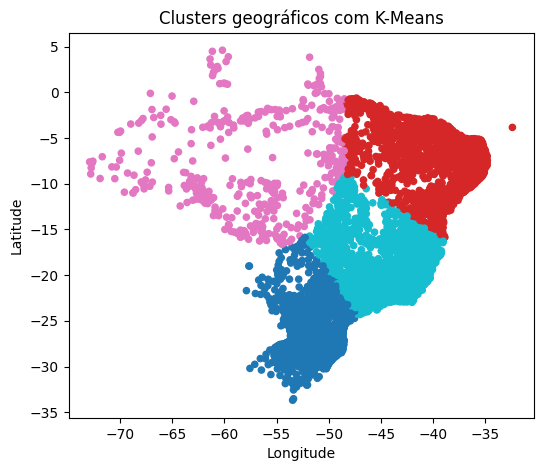

In [43]:
# Plot clusters
plt.figure(figsize=(6, 5))
plt.scatter(
    covid_df["long"],
    covid_df["lat"],
    c=labels,
    cmap="tab10",
    s=20
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters geográficos com K-Means")
plt.show()
